In [36]:
import os
import sys
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# local imports
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import utils.ambient_parameter_conversion as apc
import utils.calibration_processing as cp

DATA_DIRECTORY = os.environ.get("DATA_DIRECTORY")
PICARRO_DATA_DIRECTORy = os.environ.get("PICARRO_DATA_DIRECTORY")

In [37]:
# raw data
df_filtered = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "filtered_sbs_acropolis.parquet"))

# load calibration bottle concentrations (preprocessed)
df_gas = pl.read_csv(os.path.join(DATA_DIRECTORY,"input", "averaged_gases.csv"))

# 10m preprocessed acropolis data
df_acropolis = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "10m_cal_corr_acropolis.parquet"))

## Wet -> Dry Conversion

In [40]:
df_filtered = df_filtered.filter(pl.col("cal_gmp343_filtered") > 0) \
    .filter(pl.col("cal_gmp343_temperature") > 0) \
    .filter(pl.col("cal_bme280_pressure") > 0) \
    .with_columns(pl.col("cal_sht45_humidity").fill_null(0.0)) \
    .with_columns(pl.struct(['cal_gmp343_temperature','cal_sht45_humidity','cal_bme280_pressure'])
    .map_elements(lambda x: apc.rh_to_molar_mixing(x['cal_sht45_humidity'],apc.absolute_temperature(x['cal_gmp343_temperature']),x['cal_bme280_pressure']*100)) \
    .alias("cal_h2o_v%")) \
    .with_columns(pl.struct(['cal_gmp343_filtered','cal_gmp343_temperature','cal_sht45_humidity','cal_bme280_pressure']) \
    .map_elements(lambda x: apc.calculate_co2dry(x['cal_gmp343_filtered'],x['cal_gmp343_temperature'],x['cal_sht45_humidity'],x['cal_bme280_pressure']*100))
    .alias("cal_gmp343_dry")) \
    .collect()

In [41]:
df_filtered.select("cal_gmp343_filtered", "cal_gmp343_dry", "cal_h2o_v%").tail(10)

cal_gmp343_filtered,cal_gmp343_dry,cal_h2o_v%
f64,f64,f64
535.7,536.015787,0.058914
536.7,537.020048,0.059597
535.7,536.012889,0.058373
534.0,534.321551,0.060179
538.3,538.611922,0.057912
537.8,538.122178,0.059871
539.5,539.824882,0.060183
535.9,536.217584,0.059227
536.1,536.409186,0.05764


## Calculate Difference to Bottles

In [42]:
df_gas = df_gas.rename({"Bottle_ID":"cal_bottle_id", "CO2_dry":"cal_bottle_CO2"}) \
    .cast({"cal_bottle_id": pl.Float64})
    
df_filtered = df_filtered.filter((pl.col("cal_bottle_id") > 0) & (pl.col("cal_bottle_id") < 81)) \
    .join(df_gas, on = ["cal_bottle_id"], how= "left") \
    .with_columns(diff = pl.col("cal_gmp343_dry") - pl.col("cal_bottle_CO2"))

## Filter based on Humidity Response

In [43]:
df_temp = df_filtered.with_columns((pl.col("creation_timestamp").dt.date()).alias("date")) \
    .sort("date") \
    .group_by([pl.col("date"), pl.col("system_name"), pl.col("cal_bottle_id")]) \
    .agg([
        pl.col("cal_sht45_humidity"),
        pl.col("cal_gmp343_temperature"),
        pl.col("cal_bme280_pressure"),
        pl.col("cal_gmp343_filtered"),
        pl.col("cal_gmp343_dry"),
        pl.col("cal_bottle_CO2").last()
        ]) \
    .with_columns([
        (pl.col("cal_sht45_humidity").list.len()).alias("len"),
        pl.when(pl.col("cal_bottle_CO2") > 460).then(pl.lit("high")).otherwise(pl.lit("low")).alias("cal_bottle_span"),
        pl.col("cal_gmp343_dry").map_elements(lambda x: cp.process_bottle(x)).alias("median_cal_gmp343_dry"),
        pl.col("cal_gmp343_temperature").map_elements(lambda x: cp.process_bottle(x)).alias("median_cal_gmp343_temperature"),
        pl.col("cal_bme280_pressure").map_elements(lambda x: cp.process_bottle(x)).alias("median_cal_bme280_pressure"),
        pl.col("cal_sht45_humidity").map_elements(lambda x: cp.process_bottle(x)).alias("median_cal_sht45_humidity")
        ]) \
    .with_columns([
        (pl.col("median_cal_gmp343_dry") - pl.col("cal_bottle_CO2")).alias("diff_cut_avg_gmp343_dry")
                  ])

In [44]:
fig = px.scatter(df_temp, x="date", y="len", color = "system_name")
fig.show()

## Calculate Slope and Intercept

In [45]:
df_two_point_cal = df_temp.filter(pl.col("median_cal_gmp343_dry") > 0) \
    .sort("cal_bottle_span") \
    .group_by(["date", "system_name"]) \
    .agg([
        pl.col("cal_bottle_span"),
        pl.col("median_cal_gmp343_dry"),
        pl.col("cal_bottle_CO2")
        ]) \
    .with_columns(pl.struct(['median_cal_gmp343_dry','cal_bottle_CO2']) \
    .map_elements(lambda x: cp.two_point_calibration(x['median_cal_gmp343_dry'],x['cal_bottle_CO2'])) \
    .alias('slope, intercept')) \
    .with_columns([(pl.col("slope, intercept").list.first()).alias("slope"),
                   (pl.col("slope, intercept").list.last()).alias("intercept")]) \
    .select("date", "system_name", "slope", "intercept") \
    .filter(pl.col("slope") > 0)

In [46]:
fig = px.histogram(df_two_point_cal, x="slope", color = "system_name")
fig.show()
fig = px.histogram(df_two_point_cal, x="intercept", color = "system_name")
fig.show()

## Calculate SBS Performance

In [ ]:
# join on dataset

df_acropolis.drop("slope", "intercept", "gmp343_corrected").collect() \
    .join(df_two_point_cal, on=["date", "system_name"], how="left") \
    .with_columns([
        ((pl.col("gmp343_dry")) * pl.col("slope") + pl.col("intercept")).alias("gmp343_corrected"),
        ]) \
    .write_parquet(os.path.join(DATA_DIRECTORY, "processed", "test_10m_cal_corr_acropolis.parquet"))

## Correlation Plot

In [ ]:
corr = df_temp.join(df_two_point_cal, on=["date", "system_name"], how="left") \
    .select("median_cal_sht45_humidity", "median_cal_gmp343_temperature", "median_cal_bme280_pressure" ,"median_cal_gmp343_dry", "diff_cut_avg_gmp343_dry", "slope", "intercept") \
    .to_pandas() \
    .corr()

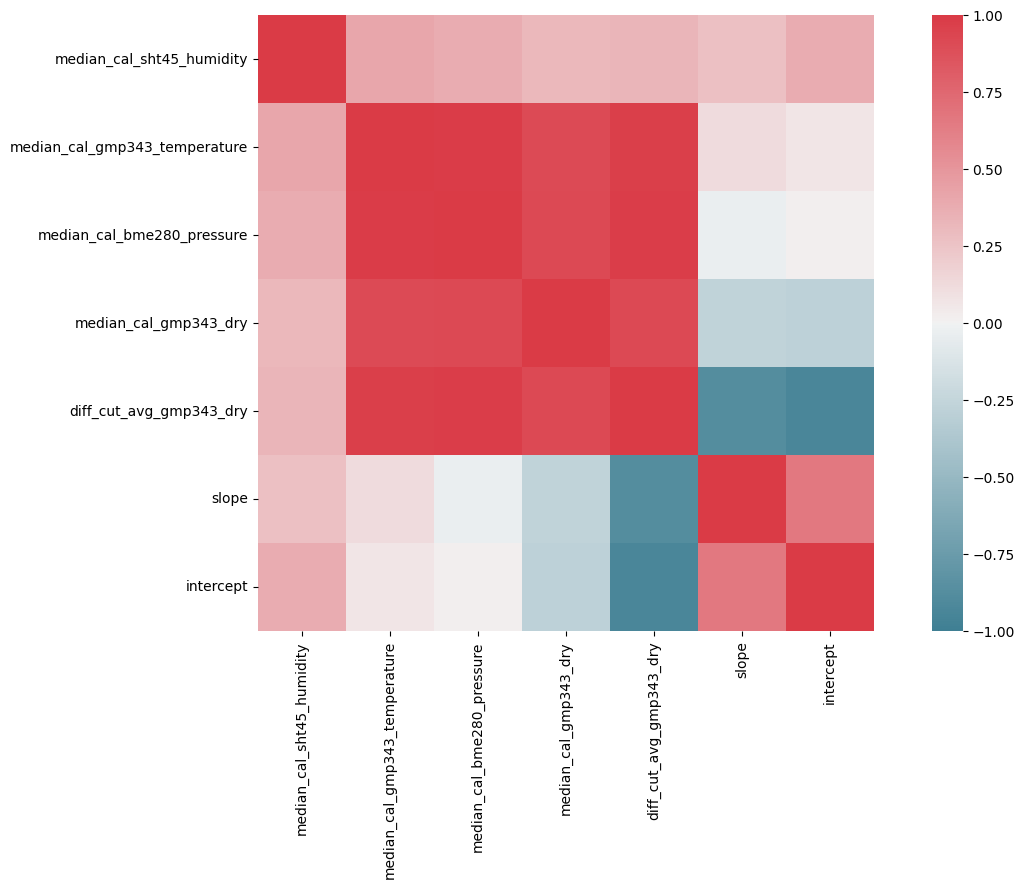

In [ ]:
plt.figure(figsize=(15,8))

sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True,
    xticklabels=1, yticklabels=1,
    )

plt.show()